In [20]:
from momentfm.utils.utils import control_randomness
import torch
control_randomness(seed=13) # Set random seeds for PyTorch, Numpy etc.

In [21]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={'task_name': 'reconstruction'} # For imputation, we will load MOMENT in `reconstruction` mode
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

In [22]:
model.init()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device).float()

In [23]:
# Number of parameters in the encoder
num_params = sum(p.numel() for p in model.encoder.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 341231104


## 3. Inputs and Outputs

Let's begin by performing a forward pass through MOMENT and examining its outputs!

MOMENT takes 3 inputs: 
1. An input time series of length $T=512$ timesteps and $C$ channels, and 
2. Two optional masks, both of length $T=512$. 
    - The input mask is utilized to regulate the time steps or patches that the model should attend to. For instance, in the case of shorter time series, you may opt not to attend to padding. To implement this, you can provide an input mask with zeros in the padded locations.  
    - The second mask, referred to simply as mask, denotes masked or unobserved values. We employ mask tokens to replace all patches containing any masked time step (for further details, refer to Section 3.2 in our [paper](https://arxiv.org/abs/2402.03885)). MOMENT can attend to these mask tokens during reconstruction.
    - By default, all time steps are observed and attended to.

MOMENT returns a `TimeseriesOutputs` object. Since this is a reconstruction task, it returns a `reconstruction` of the input. 

In [34]:
from momentfm.data.informer_dataset import InformerDataset
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Since the default InformerDataset is hardcoded to ETTh1.csv, 
# we can define a CustomInformerDataset to load any CSV file.
class CustomInformerDataset(InformerDataset):
    def __init__(self, data_path, **kwargs):
        self.data_path = data_path
        super().__init__(**kwargs)

    def _read_data(self):
        self.scaler = StandardScaler()
        df = pd.read_csv(self.data_path)
        self.length_timeseries_original = df.shape[0]
        self.n_channels = df.shape[1] - 1

        df.drop(columns=["date"], inplace=True)
        df = df.infer_objects(copy=False).interpolate(method="cubic")

        data_splits = self._get_borders()

        train_data = df[data_splits[0]]
        self.scaler.fit(train_data.values)
        df = self.scaler.transform(df.values)

        if self.data_split == "train":
            self.data = df[data_splits[0], :]
        elif self.data_split == "test":
            self.data = df[data_splits[1], :]

        self.length_timeseries = self.data.shape[0]

# You can now easily switch to a different dataset by providing its path
# For example, if you had 'data/ETTh2.csv', you could use it here.
# For now, let's try using the training split of ETTh1 as a "different" test set.
test_dataset = CustomInformerDataset(
    data_path='../data/ETTh1.csv',
    data_split='test', 
    task_name='imputation', 
    data_stride_len=512)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset

class RawInferenceDataset(Dataset):
    def __init__(self, data_path, seq_len=512, actual_len=288):
        self.seq_len = seq_len
        self.actual_len = actual_len
        
        # 1. 直接读取原始数据，不进行任何预先插值或标准化
        df = pd.read_csv(data_path)
        if 'date' in df.columns:
            df = df.drop(columns=['date'])
        
        # 2. 记录原始 NaNs 的位置 (1 表示真实缺失，需要模型填补)
        # 3. 将 NaN 替换为 0，防止 torch 报错 (模型会依据 mask 忽略这些 0)
        self.raw_data = df.values
        self.nan_mask_all = df.isna().values
        
        # 计算可以提取多少个 288 长度的样本
        self.num_samples = len(self.raw_data) // self.actual_len

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        start = index * self.actual_len
        end = start + self.actual_len
        
        # 提取 288 点并转置为 [channels, actual_len]
        chunk = self.raw_data[start:end, :].T
        nan_mask = self.nan_mask_all[start:end, :].T.astype(int)
        
        x = np.nan_to_num(chunk) # 将 NaN 转为 0
        
        # --- Padding & Masking ---
        # 数据填充： [channels, 512]
        padded_x = np.zeros((x.shape[0], self.seq_len))
        padded_x[:, :self.actual_len] = x
        
        # 填补掩码： 告知模型哪些是需要补全的原始缺失点
        padded_mask = np.zeros((x.shape[0], self.seq_len))
        padded_mask[:, :self.actual_len] = nan_mask
        
        # 输入掩码： 告知模型哪些是 Padding 位置 (1=有效, 0=Padding)
        input_mask = np.zeros(self.seq_len)
        input_mask[:self.actual_len] = 1
        
        return (
            torch.from_numpy(padded_x).float(), 
            torch.from_numpy(padded_mask).long(), 
            torch.from_numpy(input_mask).long()
        )

# 实例化
test_dataset = RawInferenceDataset(data_path='../data/ETTh1.csv', actual_len=288)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Now let's visualize the time series

In [51]:
print(test_dataset[0][0].shape)

(7, 512)


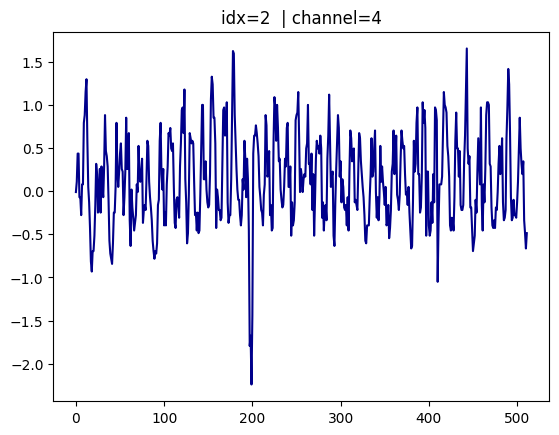

In [37]:
import numpy as np
import matplotlib.pyplot as plt

n_channels = test_dataset[0][0].shape[0]
idx = np.random.randint(0, len(test_dataset))
channel_idx = np.random.randint(0, n_channels)
plt.plot(test_dataset[idx][0][channel_idx, :].squeeze(), c='darkblue')
plt.title(f'idx={idx}  | channel={channel_idx}')
plt.show()

### 4.1 Masking Time Series Patches

Since there are no missing values in this dataset, we will randomly mask time series subsequences to evaluate MOMENT's ability to reason about missing values. Instead of masking individual time steps at random, we will mask time series patches uniformly at random using the `Masking` class.

In [38]:
from momentfm.utils.masking import Masking

mask_generator = Masking(mask_ratio=0.25) # Mask 25% of patches randomly 

### 4.2 Imputation using MOMENT

Since there are no missing values in this dataset, we will randomly mask time series subsequences to evaluate MOMENT's ability to reason about missing values. Instead of masking individual time steps at random, we will mask time series patches uniformly at random using the `Masking` class.

In [39]:
from tqdm import tqdm

trues, preds, masks = [], [], []
with torch.no_grad():
    for batch_x, batch_masks in tqdm(test_dataloader, total=len(test_dataloader)):
        trues.append(batch_x.numpy())
        
        batch_x = batch_x.to(device).float()
        n_channels = batch_x.shape[1]
        
        # Reshape to [batch_size * n_channels, 1, window_size]
        batch_x = batch_x.reshape((-1, 1, 512)) 
        
        batch_masks = batch_masks.to(device).long()
        batch_masks = batch_masks.repeat_interleave(n_channels, axis=0)
        
        mask = mask_generator.generate_mask(
            x=batch_x, input_mask=batch_masks).to(device).long()

        output = model(x_enc=batch_x, input_mask=batch_masks, mask=mask) # [batch_size, n_channels, window_size]
        
        reconstruction = output.reconstruction.detach().cpu().numpy()
        mask = mask.detach().squeeze().cpu().numpy()
        
        # Reshape back to [batch_size, n_channels, window_size]
        reconstruction = reconstruction.reshape((-1, n_channels, 512)) 
        mask = mask.reshape((-1, n_channels, 512))
                
        preds.append(reconstruction)
        masks.append(mask)

preds = np.concatenate(preds)
trues = np.concatenate(trues)
masks = np.concatenate(masks)

print(f"Shapes: preds={preds.shape} | trues={trues.shape} | masks={masks.shape}")

  0%|          | 0/1 [00:00<?, ?it/s]d:\Projects\MOMENT_Test\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
d:\Projects\MOMENT_Test\.venv\Lib\site-packages\torch\utils\checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

Shapes: preds=(6, 7, 512) | trues=(6, 7, 512) | masks=(6, 7, 512)


### 4.3 Results

Since there are no missing values in this dataset, we will randomly mask time series subsequences to evaluate MOMENT's ability to reason about missing values. Instead of masking individual time steps at random, we will mask time series patches uniformly at random using the `Masking` class.

In [40]:
from momentfm.utils.forecasting_metrics import mse, mae

print(f"Mean Squarred Error (MSE)={mse(y=trues[masks==0], y_hat=preds[masks==0], reduction='mean')}")
print(f"Mean Absolute Error (MAE)={mae(y=trues[masks==0], y_hat=preds[masks==0], reduction='mean')}")

Mean Squarred Error (MSE)=0.37626947699088764
Mean Absolute Error (MAE)=0.39496983348086345


Now let's visualize random time series windows! White patches are masked and black patches are observed.

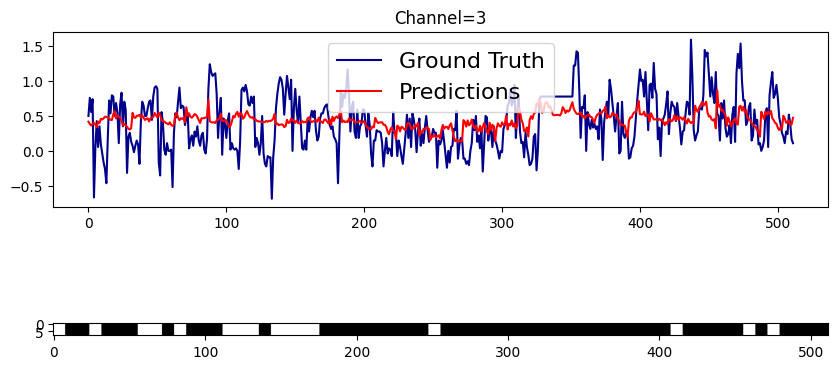

In [48]:
idx = np.random.randint(trues.shape[0])
channel_idx = np.random.randint(trues.shape[1])

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].set_title(f"Channel={channel_idx}")
axs[0].plot(trues[idx, channel_idx, :].squeeze(), label='Ground Truth', c='darkblue')
axs[0].plot(preds[idx, channel_idx, :].squeeze(), label='Predictions', c='red')
axs[0].legend(fontsize=16)

axs[1].imshow(np.tile(masks[np.newaxis, idx, channel_idx], reps=(8, 1)), cmap='binary')
plt.show()

## 5. Example Code to Fine-tune MOMENT for Imputation

To improve MOMENT's imputation performance, you can fine-tune it on any dataset. In our [paper](https://arxiv.org/abs/2402.03885), we fine-tune the final reconstruction head, but you can also fine-tune the entire model on your data. Here is some example code:

```python

# Optimize Mean Squarred Error using your favourite optimizer
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

mask_generator = Masking(mask_ratio=0.3) # Mask 30% of patches randomly 

for batch_x, batch_masks in tqdm(test_dataloader, total=len(test_dataloader)):
    n_channels = batch_x.shape[1]
    
    # Reshape to [batch_size * n_channels, 1, window_size]
    batch_x = batch_x.reshape((-1, 1, 512)) 
    
    batch_masks = batch_masks.to(device).long()
    batch_masks = batch_masks.repeat_interleave(n_channels, axis=0)
    
    # Randomly mask some patches of data
    mask = mask_generator.generate_mask(
        x=batch_x, input_mask=batch_masks).to(device).long()

    # Forward
    output = model(x_enc=batch_x, input_mask=batch_masks, mask=mask) 
    
    # Compute loss
    recon_loss = criterion(output.reconstruction, original)
    observed_mask = batch_masks * (1 - mask)
    masked_loss = observed_mask * recon_loss
    
    loss = masked_loss.nansum() / (observed_mask.nansum() + 1e-7)
    
    print(f"loss: {loss.item()}")
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```